In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
from sklearn.cluster import KMeans, SpectralClustering

from helpers.kernels import Tanimoto
from helpers.utils import deferral_metrics, get_metrics, set_matplotlib_params
from networks.nonlinearnet_aihuman import optimize_alpha, test_time_prediction

set_matplotlib_params()
warnings.filterwarnings('ignore')
seed = 13
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
rng = np.random.default_rng(seed) 
torch.set_default_dtype(torch.double)
torch.set_default_tensor_type(torch.DoubleTensor)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/miniconda3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/opt/miniconda3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [3]:
### From the undersampled training set, create two training sets: one for clf, one for human, based on K-means (K=2)

drd2_train_undersampled = pd.read_csv("datasets/drd2_train_undersampled_ECFP_counts.csv")
ndrop = 0
drop = rng.choice(range(len(drd2_train_undersampled)), ndrop, replace=False)
drd2_train_undersampled.drop(drop, inplace=True)
d = 2048

X_train_all = torch.tensor(drd2_train_undersampled[[f"bit{i}" for i in range(d)]].values, dtype=torch.double)
y_train_all = torch.tensor(drd2_train_undersampled.activity.values, dtype=torch.double)

# algo = KMeans(n_clusters=2, random_state=seed, n_init=20, max_iter=5000, init="k-means++")
# algo.fit(X_train_all)

kernel = Tanimoto()
K = kernel.K(X_train_all).numpy()
algo = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=seed, affinity='precomputed')
algo.fit(K)

c1_train = np.where(algo.labels_)[0]
c2_train = [i for i in range(len(X_train_all)) if i not in c1_train]

X_train = X_train_all[c1_train, :]
X_train_h = X_train_all[c2_train,:]

y_train = y_train_all[c1_train].unsqueeze(1)
y_train_h = y_train_all[c2_train].unsqueeze(1)

### Test set, making it balanced

drd2_test = pd.read_csv("datasets/drd2_test_ECFP_counts.csv")
X_test_all = torch.tensor(drd2_test[[f"bit{i}" for i in range(d)]].values, dtype=torch.double)
y_test_all = torch.tensor(drd2_test.activity.values, dtype=torch.double)

idx_active = torch.where(y_test_all)[0].numpy()
idx_inactive = [i for i in range(len(y_test_all)) if i not in idx_active]
idx_inactive = rng.choice(range(len(y_test_all)), 600, replace=False)
idx = np.r_[idx_active,idx_inactive]
y_test_all = y_test_all[idx]
X_test_all = X_test_all[idx]

### Validation set as a fraction of the test set

frac = .2
ntest = len(X_test_all)
nval = int(ntest * frac)
idx = rng.choice(range(ntest), nval, replace=False)
X_val = X_test_all[idx]
y_val = y_test_all[idx].unsqueeze(1)

notidx = [i for i in range(ntest) if i not in idx]
X_test_all = X_test_all[notidx]
y_test_all = y_test_all[notidx].unsqueeze(1)
print(f"Global train set size: {len(X_train_all)}")
print(f"Clf train set size: {len(X_train)}")
print(f"Human train set size: {len(X_train_h)}\n")
print(f"Validation set size: {len(X_val)}\n")
print(f"Global test set size: {len(X_test_all)}")

### We split the test set to evaluate the accuracy of clf1 and clf2 using the learned clustering

#c1 = np.where(algo.predict(X_test_all))[0]
Ktest = kernel.K(X_test_all)
c1_test = np.where(algo.fit_predict(Ktest))[0]
c2_test = [i for i in range(len(X_test_all)) if i not in c1_test]

X_test = X_test_all[c1_test, :]
X_test_h = X_test_all[c2_test,:]

y_test = y_test_all[c1_test]
y_test_h = y_test_all[c2_test]

print(f"Clf test set size: {len(X_test)}")
print(f"Human test set size: {len(X_test_h)}")

Global train set size: 2420
Clf train set size: 956
Human train set size: 1464

Validation set size: 186

Global test set size: 744
Clf test set size: 338
Human test set size: 406


In [4]:
# example usage:
num_features = X_train.shape[1]  # number of input features
dropout = 0.2
num_epochs = 150
lr = 0.1

# define the loss function and optimizer for the l2d_model
criterion = nn.BCEWithLogitsLoss()  # use BCEWithLogitsLoss for binary classification

Epoch [10/150], Loss: 0.7398613773125727
Epoch [20/150], Loss: 0.723274625477754
Epoch [30/150], Loss: 0.7052217563334879
Epoch [40/150], Loss: 0.686135816099597
Epoch [50/150], Loss: 0.6733194206676053
Epoch [60/150], Loss: 0.663550426919729
Epoch [70/150], Loss: 0.6536181372205727
Epoch [80/150], Loss: 0.6449396144035097
Epoch [90/150], Loss: 0.6381030269242385
Epoch [100/150], Loss: 0.6343394252024439
Epoch [110/150], Loss: 0.6289197414909371
Epoch [120/150], Loss: 0.6242911193340467
Epoch [130/150], Loss: 0.6207928270590416
Epoch [140/150], Loss: 0.6175264053429217
Epoch [150/150], Loss: 0.6136170991337315
0.1 0.6974358974358975
Epoch [10/150], Loss: 0.8288236567830216
Epoch [20/150], Loss: 0.8013069611951286
Epoch [30/150], Loss: 0.7863227402059867
Epoch [40/150], Loss: 0.7746483084338018
Epoch [50/150], Loss: 0.7650263147956811
Epoch [60/150], Loss: 0.7573203255846587
Epoch [70/150], Loss: 0.7517392224796314
Epoch [80/150], Loss: 0.7470260820642964
Epoch [90/150], Loss: 0.7436021

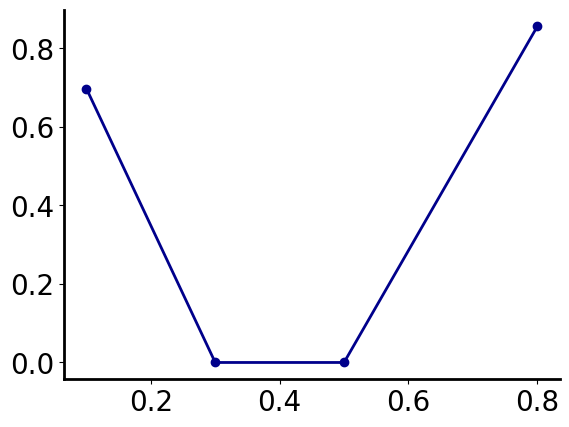

In [5]:
alpha_grid = [.1,.3,.5,.8]
best_alpha, l2d_model, F1s = optimize_alpha(alpha_grid, lr, num_features, dropout, num_epochs, X_val, y_val, X_train, X_train_h, y_train, y_train_h, criterion)

plt.plot(alpha_grid, F1s, marker='o', color='darkblue')
plt.show()

In [6]:
metrics = {}
test_labels = [y_test, y_test_h]
test_features = [X_test, X_test_h]

print('Metrics computed using same distributions for train and test set')
for i in range(2):
    final_predictions, pred_clf, boolean, combined_outputs, decision_outputs = test_time_prediction(l2d_model, test_features[i])
    metrics[f"clf_{i+1}"] = get_metrics(test_labels[i], pred_clf[:, i])
print (json.dumps(metrics, indent=2, default=str))
metrics = {}
# for the system, we use the global test set
print('Metrics computed using the whole test set')
final_predictions, pred_clf, boolean, combined_outputs, decision_outputs = test_time_prediction(l2d_model, X_test_all)
for i in range(2):
    metrics[f"clf_{i+1}"] = get_metrics(y_test_all, pred_clf[:, i])
metrics[f"system"] = get_metrics(y_test_all, final_predictions)
print (json.dumps(metrics, indent=2, default=str))
print(f"Percentage of deferral: {boolean.mean()}")
for i in range(2):
     print(f'--- For label {i} ---')
     ndefer, ndefersuccess, ndeferuseful = deferral_metrics(y_test_all.squeeze(), pred_clf, boolean, i)
     print(f"Deferral: {ndefer} / {(y_test_all == i).sum()}")
     print(f"Successful deferrals: {ndefersuccess} / {ndefer}")
     print(f"Useful deferrals: {ndeferuseful} / {ndefersuccess}\n")
# print(f"of which {} were successful defers")

# print(f"Deferral for negative samples: {boolean[(y_test_all == 0).squeeze()].mean()}")

Metrics computed using same distributions for train and test set
{
  "clf_1": {
    "Accuracy": 0.9289940828402367,
    "Precision": 0.938156136667303,
    "Recall": 0.9289940828402367,
    "F1-Score": 0.9288447852852328
  },
  "clf_2": {
    "Accuracy": 0.9729064039408867,
    "Precision": 0.9729675407498809,
    "Recall": 0.9729064039408867,
    "F1-Score": 0.9729304382126575
  }
}
Metrics computed using the whole test set
{
  "clf_1": {
    "Accuracy": 0.8776881720430108,
    "Precision": 0.9062275985663083,
    "Recall": 0.8776881720430108,
    "F1-Score": 0.8788001765241651
  },
  "clf_2": {
    "Accuracy": 0.9032258064516129,
    "Precision": 0.917604201249932,
    "Recall": 0.9032258064516129,
    "F1-Score": 0.9041480725912704
  },
  "system": {
    "Accuracy": 0.8776881720430108,
    "Precision": 0.9062275985663083,
    "Recall": 0.8776881720430108,
    "F1-Score": 0.8788001765241651
  }
}
Percentage of deferral: 0.1895161271095276
--- For label 0 ---
Deferral: 141 / 445
Succe

In [7]:
## Individual metrics

for i in range(len(X_test_all)):
    print(
        f"y = {y_test_all[i].item()},", 
        f"classifier pred = {combined_outputs[i,0]:.3f},", 
        f"hum model pred = {combined_outputs[i,1]:.3f}",
        "deferred" if boolean[i] else "NOT deferred"
    )

y = 1.0, classifier pred = 0.997, hum model pred = 0.988 NOT deferred
y = 1.0, classifier pred = 0.992, hum model pred = 0.967 NOT deferred
y = 1.0, classifier pred = 0.948, hum model pred = 0.726 NOT deferred
y = 1.0, classifier pred = 0.996, hum model pred = 0.938 NOT deferred
y = 1.0, classifier pred = 0.976, hum model pred = 0.972 NOT deferred
y = 1.0, classifier pred = 0.994, hum model pred = 0.988 NOT deferred
y = 1.0, classifier pred = 0.981, hum model pred = 0.969 NOT deferred
y = 1.0, classifier pred = 0.991, hum model pred = 0.972 NOT deferred
y = 1.0, classifier pred = 0.974, hum model pred = 0.946 NOT deferred
y = 1.0, classifier pred = 0.979, hum model pred = 0.977 NOT deferred
y = 1.0, classifier pred = 0.917, hum model pred = 0.951 NOT deferred
y = 1.0, classifier pred = 0.985, hum model pred = 0.956 NOT deferred
y = 1.0, classifier pred = 0.908, hum model pred = 0.463 NOT deferred
y = 1.0, classifier pred = 0.993, hum model pred = 0.975 NOT deferred
y = 1.0, classifier 

In [8]:
best_alpha

0.8

In [ ]:
torch.save(l2d_model.state_dict(), "models/l2d_model_demo2.pt")

In [ ]:
drd2_train_undersampled.iloc[c1_train].rename(columns = {"activity": "activity_y"}).to_csv("datasets/drd2_train_undersampled_y_ECFP_counts.csv")
drd2_train_undersampled.iloc[c2_train].rename(columns = {"activity": "activity_h"}).to_csv("datasets/drd2_train_undersampled_h_ECFP_counts.csv")